In [1]:
# Along-fjord Momentum Balance terms
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
Qsg = 700
hs = 9
File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/kpp_state_' + str(format(hs,'03d')) + '.nc')
T0 = 81
Tn = len(File1.T)
State1 = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))
State2 = File2.isel(X=range(120), Y=range(30,39), T=range(T0-1,Tn-1))

# U (T,Z,Y,Xp1) W(T,Zl,Y,X) KPPviscAz(T-1,Z,Y,X)
U = State1.U.data.mean(axis=(0,2))
u = (U[:, 1:] + U[:, :-1]) / 2
W0 = State1.W.data.mean(axis=(0,2))
Wbt = np.zeros((1,W0.shape[1])) # Add vertical velocity (0 m/s) at the bottom
W = np.concatenate((W0, Wbt), axis=0)
w = (W[1:, :] + W[:-1, :]) / 2
#W = np.concatenate((W0, Wbt), axis=0)
Az = State2.KPPviscAz.data.mean(axis=(0,2)) # Vetical eddy viscosity (m^2/s)
s = State1.S.data.mean(axis=(0,2)) # Salinity
x = State1.X.data
z = State1.Z.data
#file2.KPPviscAz
#X, Z = np.meshgrid(x, z)
mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
u[mask] = np.nan
w[mask] = np.nan
Az[mask] = np.nan


In [3]:
# Along-fjord velocity gradients
ux = np.gradient(u, x, axis=1)
uz = np.gradient(u, z, axis=0)
# Advective terms
Adv_h = u * ux
Adv_v = w * uz
# Viscous term
Visc = np.gradient(Az*uz, z, axis=0) #(Az*Uz)z

range1 = np.array([np.nanmax(Adv_h), np.nanmin(Adv_h), np.nanmean(Adv_h)])
range2 = np.array([np.nanmax(Adv_v), np.nanmin(Adv_v), np.nanmean(Adv_v)])
range3 = np.array([np.nanmax(Visc), np.nanmin(Visc), np.nanmean(Visc)])
range1, range2, range3

(array([ 5.5068661e-04, -7.8573567e-04, -5.2460547e-07], dtype=float32),
 array([ 9.97506431e-04, -1.04414650e-03, -2.79853636e-06]),
 array([ 3.9120782e-03, -1.7102175e-04,  3.7633845e-06], dtype=float32))

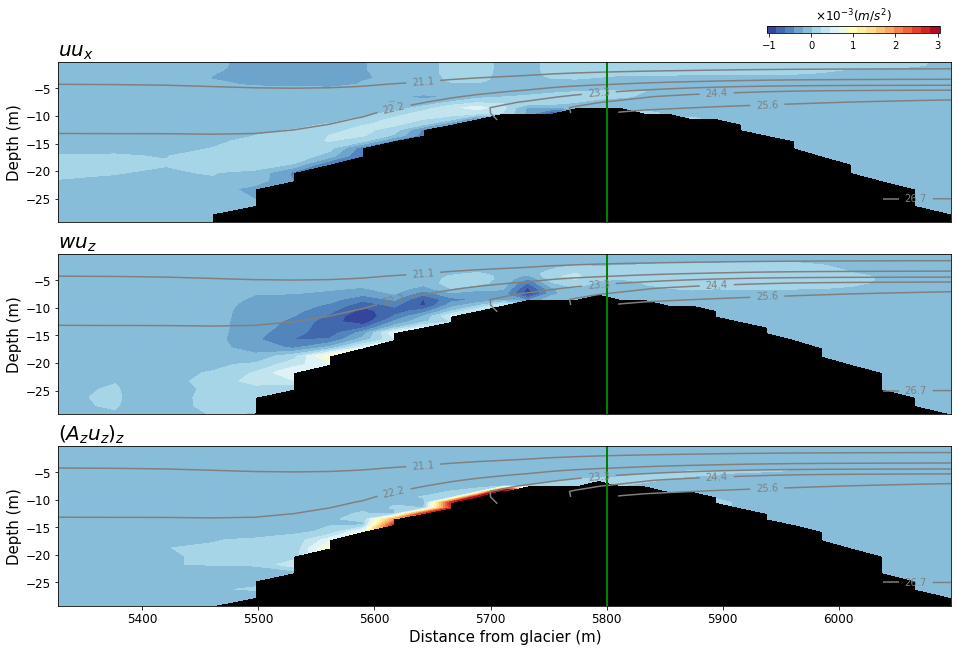

In [4]:
fig1 = plt.figure(figsize=(16,10))
fig1.tight_layout()

cm = np.linspace(-1.05,3.05,20) # Contour range for momentum terms
cs = np.linspace(20,30,10)
cmap = 'RdYlBu_r'

Xl, Xr = 55, 85 # X range
Zu, Zl = 0, 30 # Z range

# Horizontal Advective Term Plot
ax1 = fig1.add_subplot(311)
im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], Adv_h[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap)
ax1.xaxis.set_visible(False)
ax1.set_xlim([x[Xl], x[Xr-1]])
ax1.set_facecolor('k')

cbaxes = fig1.add_axes([0.74, 0.92, 0.15, 0.01])
cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-1, 0, 1, 2, 3])
cbar.ax.set_title(r'$\times10^{-3}(m/s^2)$', size=12, weight='bold')
# Plot isohalines
CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS1, fmt='%1.1f', fontsize=10, inline=1)
ax1.axvline(x=5800, color='g',lw=2)
ax1.set_ylabel('Depth (m)', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title(r'$uu_x$', loc='left', size=20, weight='bold')



# Vertical Advective Term Plot
ax2 = fig1.add_subplot(312)
im2 = ax2.contourf(x[Xl:Xr], z[Zu:Zl], Adv_v[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap)
ax2.xaxis.set_visible(False)
ax2.set_xlim([x[Xl], x[Xr-1]])
ax2.set_facecolor('k')
# Plot isohalines
CS2 = ax2.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS2, fmt='%1.1f', fontsize=10, inline=1)
ax2.axvline(x=5800, color='g',lw=2)
ax2.set_ylabel('Depth (m)', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title(r'$wu_z$', loc='left', size=20, weight='bold')



# qf-tide Plot
ax3 = fig1.add_subplot(313)
im3 = ax3.contourf(x[Xl:Xr], z[Zu:Zl], Visc[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap)
ax3.set_xlim([x[Xl], x[Xr-1]])
ax3.set_facecolor('k')
# Plot isohalines
CS3 = ax3.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS3, fmt='%1.1f', fontsize=10, inline=1)
ax3.axvline(x=5800, color='g',lw=2)
ax3.set_ylabel('Depth (m)', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title(r'$(A_z{u_z})_z$', loc='left', size=20, weight='bold')
ax3.set_xlabel('Distance from glacier (m)', size=15)
ax3.tick_params(labelsize=12)


In [ ]:
x[71], x[72]

In [5]:
def AF_Momentum(Qsg, hs):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
    file2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/kpp_state_' + str(format(hs,'03d')) + '.nc')
    t0 = 81
    tn = len(file1.T)
    state1 = file1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(t0,tn))
    state2 = file2.isel(X=range(120), Y=range(30,39), T=range(t0-1,tn-1))

    # U (T,Z,Y,Xp1) W(T,Zl,Y,X) KPPviscAz(T-1,Z,Y,X)
    U = state1.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    W0 = state1.W.data.mean(axis=(0,2))
    Wbt = np.zeros((1,W0.shape[1])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, Wbt), axis=0)
    w = (W[1:, :] + W[:-1, :]) / 2
    #W = np.concatenate((W0, Wbt), axis=0)
    Az = state2.KPPviscAz.data.mean(axis=(0,2)) # Vetical eddy viscosity (m^2/s)
    s = state1.S.data.mean(axis=(0,2)) # Salinity
    x = state1.X.data
    z = state1.Z.data
    #file2.KPPviscAz
    #X, Z = np.meshgrid(x, z)
    mask = (s == 0) # Exclude data covered by the sill
    s[mask] = np.nan
    u[mask] = np.nan
    w[mask] = np.nan
    Az[mask] = np.nan
    
    # Along-fjord velocity gradients
    ux = np.gradient(u, x, axis=1)
    uz = np.gradient(u, z, axis=0)
    # Advective terms
    Adv_h = u * ux
    Adv_v = w * uz
    # Viscous term
    Visc = np.gradient(Az*uz, z, axis=0) #(Az*Uz)z
    
    return (Adv_h, Adv_v, Visc)

In [6]:
sd = np.array([9, 12, 15, 18, 30])
Qf = 700
X0, Xs = 55, 72 # X range for the sill slope

ADVh = np.empty(len(sd))
ADVv = np.empty(len(sd))
Vis = np.empty(len(sd))
for i in range(len(sd)):
    advh, advv, visc = AF_Momentum(Qf, sd[i])
    ADVh[i] = np.nanmean(advh[Zu:Zl, X0:Xs])
    ADVv[i] = np.nanmean(advv[Zu:Zl, X0:Xs])
    Vis[i] = np.nanmean(visc[Zu:Zl, X0:Xs])

ADVh, ADVv, Vis

(array([-4.17868287e-05, -1.00987709e-05,  7.59899012e-06,  1.29548489e-05,
         8.17261571e-06]),
 array([-6.36923918e-05, -5.03188129e-05, -4.54871930e-05, -3.00666574e-05,
        -2.16341659e-06]),
 array([ 5.71324817e-05,  4.48662904e-05,  8.88739487e-06,  9.97884763e-06,
        -6.53103243e-08]))

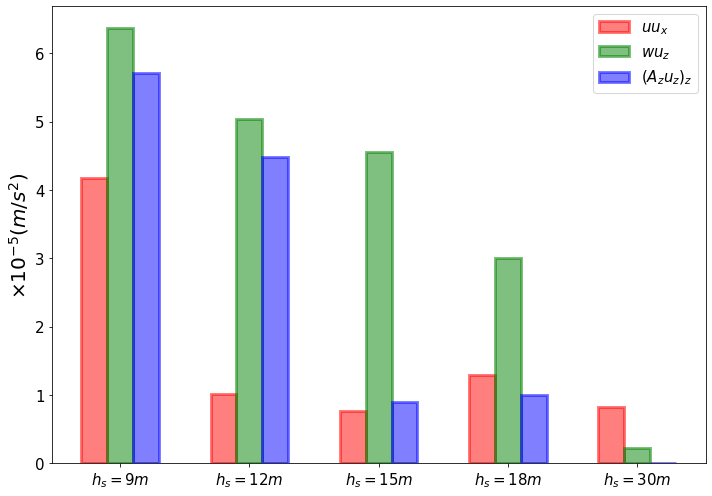

In [25]:
#labels = [r'$uu_x$', r'$wu_z$', r'$(A_z{u_z})_z$']
labels = [r'$h_s=9m$', r'$h_s=12m$', r'$h_s=15m$', r'$h_s=18m$', r'$h_s=30m$']


N = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


fig2, ax = plt.subplots(figsize=(10,7))

ax.bar(N - width, np.abs(ADVh)*1e5, width, label=r'$uu_x$', facecolor='r', edgecolor='r', linewidth=3, alpha=.5)
ax.bar(N , np.abs(ADVv)*1e5, width, label=r'$wu_z$', facecolor='g', edgecolor='g', linewidth=3, alpha=.5)
ax.bar(N + width, np.abs(Vis)*1e5, width, label=r'$(A_z{u_z})_z$', facecolor='b', edgecolor='b', linewidth=3, alpha=.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\times10^{-5}(m/s^2)$', fontsize=20)
#ax.set_title('Scores by group and gender')
ax.set_xticks(N)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig2.tight_layout()

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1.savefig(fig_path + '/Mo.png', dpi=200, bbox_inches='tight')